Tienda Online 

Objetivo: Aumento de ingresos

Actividades a ejecutar: 
* Priorizar Hipótesis
* Tests A/B
* Análisis de resultados

In [2]:
# Se importan librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datasets
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')


In [3]:
# Preprocesamiento para 'hypotheses'
# Mostrar las primeras filas y tipos de datos para 'hypotheses' antes de cambiar los nombres
print("\n--- Info inicial de 'hypotheses' ---")
print(hypotheses.head())
print(hypotheses.info())

# Renombrar columnas para 'hypotheses' a snake_case (si es necesario)
# Ya que los nombres de las columnas 'Hypotheses', 'Reach', 'Impact', 'Confidence', 'Effort'
# no siguen snake_case, los renombraremos.
hypotheses.columns = [col.lower().replace(' ', '_') for col in hypotheses.columns]
print("\n--- Columnas de 'hypotheses' después de renombrar ---")
print(hypotheses.columns)



--- Info inicial de 'hypotheses' ---
                                          Hypothesis  Reach  Impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   Confidence  Effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int

In [4]:
# Preprocesamiento para 'orders'
print("\n--- Info inicial de 'orders' ---")
print(orders.head())
print(orders.info())

# Renombrar columnas para 'orders' a snake_case
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

# Convertir la columna 'date' a datetime
orders['date'] = pd.to_datetime(orders['date'])
print("\n--- Info de 'orders' después de preprocesamiento ---")
print(orders.info())


--- Info inicial de 'orders' ---
   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     30.4     B
1     2804400009  3642806036  2019-08-15     15.2     B
2     2961555356  4069496402  2019-08-15     10.2     A
3     3797467345  1196621759  2019-08-15    155.1     B
4     2282983706  2322279887  2019-08-15     40.5     B
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None

--- Info de 'orders' después de preprocesamiento ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 

In [5]:
# Preprocesamiento para 'visits'
print("\n--- Info inicial de 'visits' ---")
print(visits.head())
print(visits.info())

# Renombrar columnas para 'visits' a snake_case
visits.columns = ['date', 'group', 'visits']

# Convertir la columna 'date' a datetime
visits['date'] = pd.to_datetime(visits['date'])
print("\n--- Info de 'visits' después de preprocesamiento ---")
print(visits.info())


--- Info inicial de 'visits' ---
         date group  visits
0  2019-08-01     A     719
1  2019-08-02     A     619
2  2019-08-03     A     507
3  2019-08-04     A     717
4  2019-08-05     A     756
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None

--- Info de 'visits' después de preprocesamiento ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None


In [6]:
# Manejar usuarios que están en ambos grupos A/B
# Encontrar usuarios que están en ambos grupos
group_a_users = orders[orders['group'] == 'A']['visitor_id'].unique()
group_b_users = orders[orders['group'] == 'B']['visitor_id'].unique()

# Identificar usuarios que aparecen en ambos grupos
ab_overlap_users = pd.Series(list(set(group_a_users) & set(group_b_users)))

print(f"\nNúmero de usuarios en el grupo A: {len(group_a_users)}")
print(f"Número de usuarios en el grupo B: {len(group_b_users)}")
print(f"Número de usuarios que aparecen en ambos grupos: {len(ab_overlap_users)}")

# Filtrar los pedidos y visitas para excluir a estos usuarios
orders_filtered = orders[~orders['visitor_id'].isin(ab_overlap_users)]
print(f"Órdenes después de filtrar usuarios duplicados: {orders_filtered.shape[0]}")





Número de usuarios en el grupo A: 503
Número de usuarios en el grupo B: 586
Número de usuarios que aparecen en ambos grupos: 58
Órdenes después de filtrar usuarios duplicados: 1016


# Parte 1: Priorización de hipótesis

* Aplicar framework ICE para priorizar hipótesis

In [7]:
# Vamos a calcular el score ICE para cada hipótesis y luego las ordenaremos de forma descendente

# Calcular el score ICE
hypotheses['ice'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

# Ordenar las hipótesis por ICE en orden descendente
hypotheses_ice = hypotheses.sort_values(by='ice', ascending=False)

print("--- Priorización de hipótesis con el framework ICE ---")
print(hypotheses_ice[['hypothesis', 'ice']].round(2))

--- Priorización de hipótesis con el framework ICE ---
                                          hypothesis    ice
8  Launch a promotion that gives users discounts ...  16.20
0  Add two new channels for attracting traffic. T...  13.33
7  Add a subscription form to all the main pages....  11.20
6  Show banners with current offers and sales on ...   8.00
2  Add product recommendation blocks to the store...   7.00
1  Launch your own delivery service. This will sh...   2.00
5  Add a customer review page. This will increase...   1.33
3  Change the category structure. This will incre...   1.12
4  Change the background color on the main page. ...   1.00


* Aplicar el framework RICE

In [8]:
# Calcular el score RICE
hypotheses['rice'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

# Ordenar las hipótesis por RICE en orden descendente
hypotheses_rice = hypotheses.sort_values(by='rice', ascending=False)

print("\n--- Priorización de hipótesis con el framework RICE ---")
print(hypotheses_rice[['hypothesis', 'rice']].round(2))


--- Priorización de hipótesis con el framework RICE ---
                                          hypothesis   rice
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


* Mostrar cambios en la priorizacion 

In [9]:
print("\n--- Comparación de priorización ICE vs RICE ---")
print(hypotheses_ice[['hypothesis', 'ice']].round(2))
print("\n")
print(hypotheses_rice[['hypothesis', 'rice']].round(2))


--- Comparación de priorización ICE vs RICE ---
                                          hypothesis    ice
8  Launch a promotion that gives users discounts ...  16.20
0  Add two new channels for attracting traffic. T...  13.33
7  Add a subscription form to all the main pages....  11.20
6  Show banners with current offers and sales on ...   8.00
2  Add product recommendation blocks to the store...   7.00
1  Launch your own delivery service. This will sh...   2.00
5  Add a customer review page. This will increase...   1.33
3  Change the category structure. This will incre...   1.12
4  Change the background color on the main page. ...   1.00


                                          hypothesis   rice
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts 

La principal diferencia entre ICE y RICE radica en la inclusión del componente Reach en el framework RICE.

ICE se centra en el impacto, la confianza y el esfuerzo. Una hipótesis con un alto impacto y confianza, y un bajo esfuerzo, tendrá una puntuación ICE alta, independientemente de cuántos usuarios se vean afectados.
RICE añade el alcance, lo que significa que una hipótesis que puede afectar a un gran número de usuarios, incluso si su impacto individual no es el más alto, puede subir significativamente en la priorización.
Al comparar los dos listados, verás que algunas hipótesis que tenían una buena puntuación en ICE (quizás por un alto impacto o confianza) pueden bajar en la lista de RICE si su alcance es limitado. Por el contrario, hipótesis con un alcance muy amplio, aunque su impacto o confianza sean moderados, pueden ascender considerablemente en la priorización RICE.

Esto resalta la importancia de considerar la cantidad de usuarios impactados al priorizar iniciativas, especialmente en productos con una gran base de usuarios. RICE proporciona una visión más completa al tener en cuenta la escala potencial de la mejora.

Aquí, la hipótesis "Launch a promotion that gives users discounts..." (puesto 8) tiene la puntuación más alta (16.20). Esto sugiere que esta hipótesis, a pesar de no tener un alcance necesariamente amplio, se percibe como altamente impactante y confiable, con un esfuerzo relativamente bajo. Otras hipótesis como "Add two new channels for attracting traffic..." (puesto 0) también tienen una buena puntuación ICE, lo que indica una buena relación entre impacto, confianza y esfuerzo.

Al observar la priorización RICE, la hipótesis "Add a subscription form to all the main pages..." (puesto 7) se dispara a la primera posición con una puntuación de 112.0. Esto indica que, aunque su puntuación ICE no era la más alta, tiene un alcance excepcionalmente amplio, afectando a una gran cantidad de usuarios. Esto la convierte en una candidata principal para la implementación, ya que su potencial impacto general es muy alto debido a la cantidad de personas que alcanzaría.

De manera similar, la hipótesis "Add product recommendation blocks to the store..." (puesto 2), que estaba en la mitad de la tabla de ICE (7.00), sube considerablemente en RICE (56.0). Esto sugiere que, a pesar de quizás no tener el impacto individual más alto, puede llegar a muchos usuarios, lo que la hace valiosa.

Por otro lado, la hipótesis "Launch a promotion that gives users discounts..." (puesto 8), que era la primera en ICE, cae significativamente en la priorización RICE (16.2). Esto implica que, aunque es muy prometedora en términos de impacto por usuario y confianza con bajo esfuerzo, su alcance es mucho más limitado en comparación con otras hipótesis.

Conclusión sobre los Cambios

El cambio en la priorización se debe fundamentalmente a la incorporación del "Alcance" en RICE.

ICE es útil para identificar iniciativas con un alto potencial de impacto por usuario, donde el esfuerzo es bajo y la confianza es alta. Es ideal cuando el enfoque es maximizar el valor de cada interacción.

RICE es más adecuado cuando la escala y el número de usuarios afectados son consideraciones críticas. Permite identificar iniciativas que, aunque quizás no tengan el impacto individual más alto, pueden generar un retorno significativo debido a su capacidad de llegar a una gran audiencia.
En tu caso, las hipótesis relacionadas con la interfaz de usuario o funcionalidad central que ven todos los visitantes (como un formulario de suscripción o bloques de recomendación) tienden a subir en la priorización RICE debido a su inherente alto alcance, mientras que las promociones o canales específicos pueden tener un alcance más limitado, cayendo en la priorización RICE a pesar de un buen ICE.



# Parte 2. Análisis de test A/B

1. Representar gráficamente el ingreso acumulado por grupo


Gráfico de ingresos acumulados


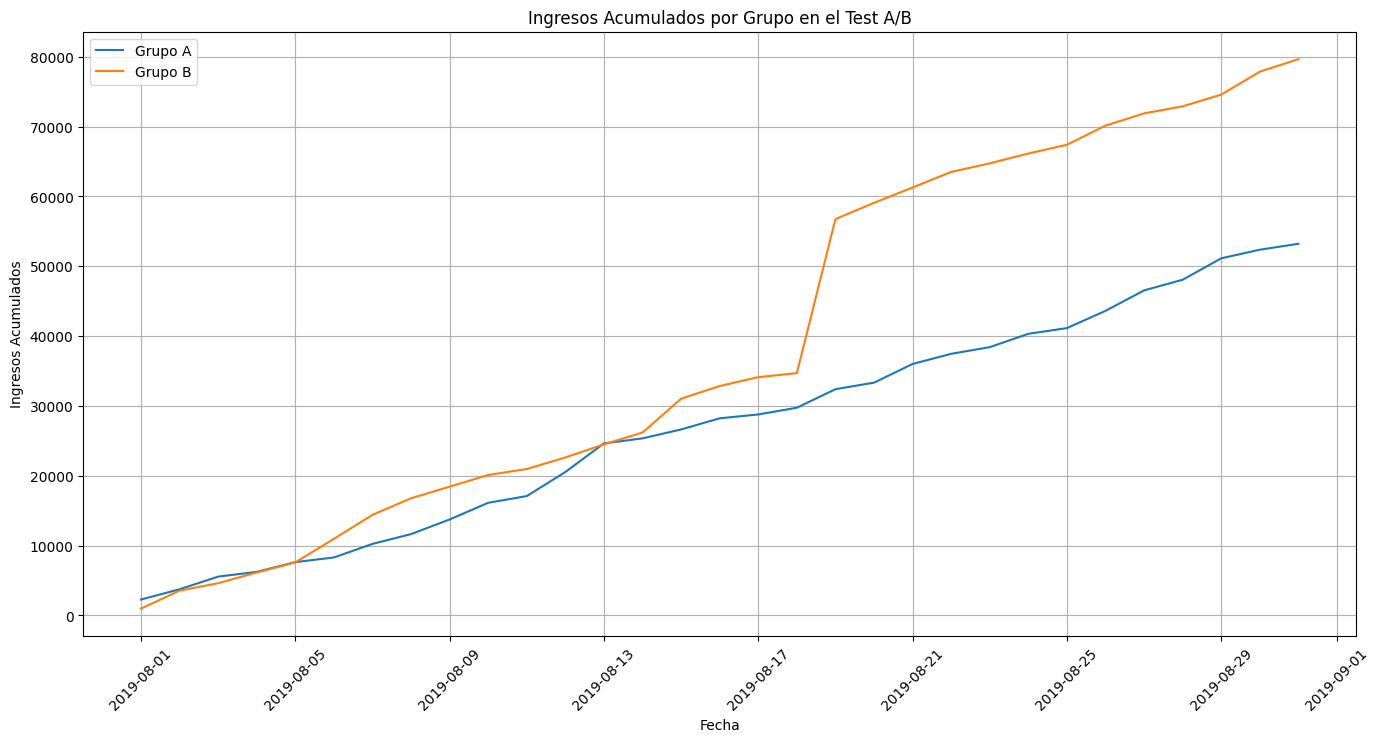

In [10]:
# Preparar los datos para el gráfico de ingreso acumulado

# Crear un DataFrame con fechas y grupos únicos para asegurar que todas las combinaciones de fecha-grupo estén presentes
# Esto es importante para el cálculo acumulativo, incluso si no hubo pedidos un día determinado.
dates_groups = orders_filtered[['date', 'group']].drop_duplicates().sort_values(by=['date', 'group'])

# Agrupar los pedidos por fecha y grupo para obtener los totales diarios
daily_orders = orders_filtered.groupby(['date', 'group']).agg({
    'transaction_id': 'nunique', # Contar transacciones únicas
    'revenue': 'sum'             # Sumar el ingreso total
}).reset_index()
daily_orders.columns = ['date', 'group', 'orders', 'revenue']

# Unir los datos de visitas diarias
# Es crucial para tener un conjunto completo de datos diarios, incluso si un grupo no tuvo pedidos.
# Usamos un 'outer' join o un 'left' join con dates_groups para no perder fechas.
daily_combined_data = pd.merge(dates_groups, daily_orders, on=['date', 'group'], how='left')
daily_combined_data = pd.merge(daily_combined_data, visits, on=['date', 'group'], how='left')

# Rellenar los valores nulos (días sin pedidos) con 0
daily_combined_data['orders'] = daily_combined_data['orders'].fillna(0)
daily_combined_data['revenue'] = daily_combined_data['revenue'].fillna(0)
daily_combined_data['visits'] = daily_combined_data['visits'].fillna(0)

# Asegurar que los datos estén ordenados por fecha para el cálculo acumulativo
daily_combined_data.sort_values(by=['date', 'group'], inplace=True)

# Calcular el ingreso acumulado para cada grupo
cumulative_revenue_A = daily_combined_data[daily_combined_data['group'] == 'A'][['date', 'revenue']].copy()
cumulative_revenue_A['cumulative_revenue'] = cumulative_revenue_A['revenue'].cumsum()
cumulative_revenue_A.columns = ['date', 'daily_revenue', 'cumulative_revenue']

cumulative_revenue_B = daily_combined_data[daily_combined_data['group'] == 'B'][['date', 'revenue']].copy()
cumulative_revenue_B['cumulative_revenue'] = cumulative_revenue_B['revenue'].cumsum()
cumulative_revenue_B.columns = ['date', 'daily_revenue', 'cumulative_revenue']

# Representar gráficamente el ingreso acumulado por grupo
plt.figure(figsize=(14, 7))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['cumulative_revenue'], label='Grupo A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['cumulative_revenue'], label='Grupo B')

plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Ingresos Acumulados por Grupo en el Test A/B')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45) # Rotar las etiquetas del eje X para mayor legibilidad
plt.savefig('cumulative_revenue_plot.png')
print("\nGráfico de ingresos acumulados")

Observaciones Clave:

La línea azul (Grupo A) muestra un crecimiento de ingresos acumulados relativamente lineal y constante a lo largo de todo el período del test.

La línea naranja (Grupo B) muestra un crecimiento de ingresos similar al Grupo A en la primera mitad del test. Sin embargo, alrededor del 19 de agosto, la línea naranja experimenta un salto vertical muy pronunciado, superando drásticamente al Grupo A. Después de este pico, el Grupo B continúa creciendo, pero la diferencia con el Grupo A ya es muy grande debido a este evento.

Conclusiones y Conjeturas:

Existe un valor atípico significativo (uno o más pedidos de un valor extraordinariamente alto) que ocurrió en el Grupo B alrededor del 19 de agosto. Este evento es el principal impulsor de la gran diferencia de ingresos acumulados entre los dos grupos.

Sin este valor atípico, la curva de ingresos del Grupo B probablemente se parecería mucho más a la del Grupo A, y la diferencia total de ingresos sería mucho menor.

Es crucial identificar y, posiblemente, excluir este tipo de valores atípicos para obtener una evaluación justa del rendimiento de cada grupo.

2. Representa gráficamente el tamaño promedio acumulado por grupo


Gráfico de tamaño de pedido promedio acumulado


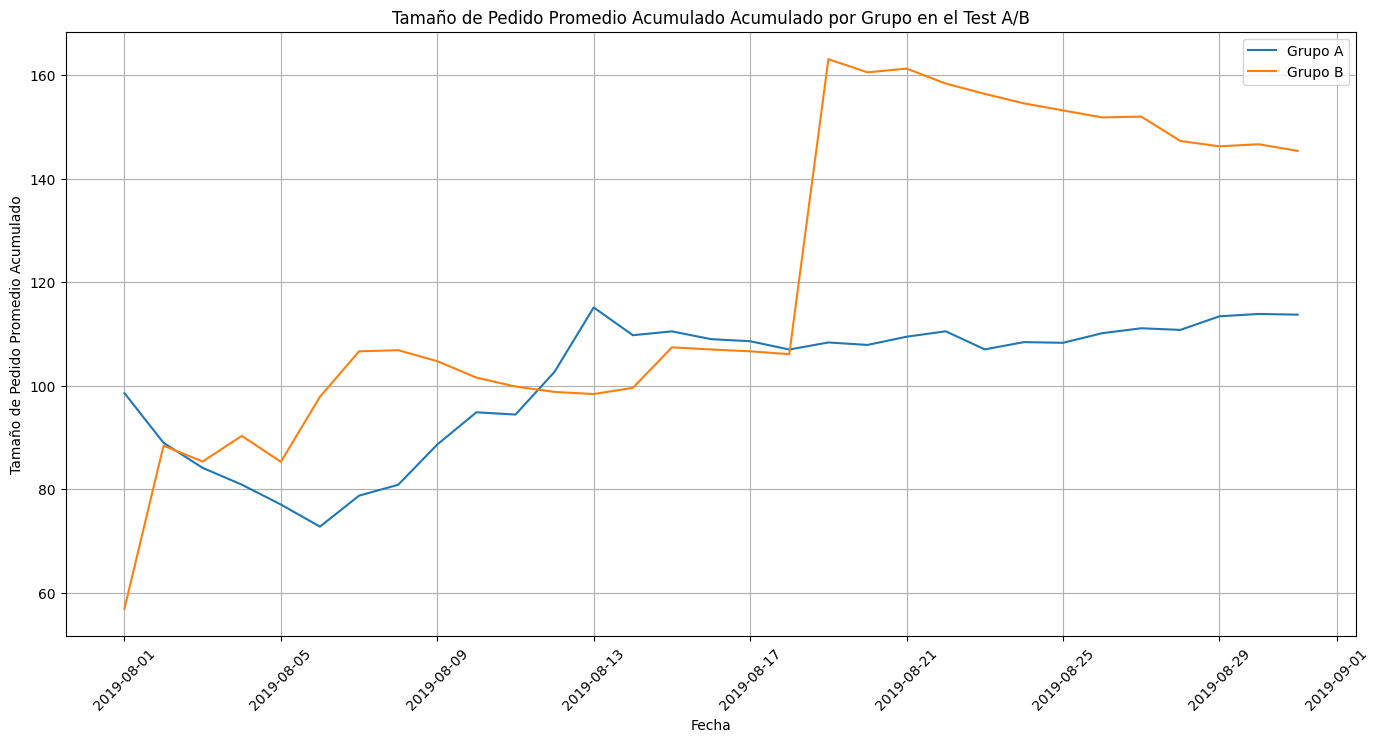

In [12]:
# Calcular el ingreso y órdenes acumuladas para cada grupo
cumulative_data_A = daily_combined_data[daily_combined_data['group'] == 'A'].copy()
cumulative_data_A['cumulative_revenue'] = cumulative_data_A['revenue'].cumsum()
cumulative_data_A['cumulative_orders'] = cumulative_data_A['orders'].cumsum()

cumulative_data_B = daily_combined_data[daily_combined_data['group'] == 'B'].copy()
cumulative_data_B['cumulative_revenue'] = cumulative_data_B['revenue'].cumsum()
cumulative_data_B['cumulative_orders'] = cumulative_data_B['orders'].cumsum()

# Evitar división por cero si cumulative_orders es 0 al inicio
cumulative_data_A['avg_order_size'] = cumulative_data_A['cumulative_revenue'] / cumulative_data_A['cumulative_orders'].replace(0, pd.NA)
cumulative_data_B['avg_order_size'] = cumulative_data_B['cumulative_revenue'] / cumulative_data_B['cumulative_orders'].replace(0, pd.NA)

# Calcular el tamaño de pedido promedio acumulado
# Representar gráficamente el tamaño de pedido promedio acumulado
plt.figure(figsize=(14, 7))
plt.plot(cumulative_data_A['date'], cumulative_data_A['avg_order_size'], label='Grupo A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['avg_order_size'], label='Grupo B')

plt.xlabel('Fecha')
plt.ylabel('Tamaño de Pedido Promedio Acumulado')
plt.title('Tamaño de Pedido Promedio Acumulado Acumulado por Grupo en el Test A/B')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('cumulative_avg_order_size_plot.png')
print("\nGráfico de tamaño de pedido promedio acumulado")

Grupo A (Línea Azul): Su tamaño de pedido promedio acumulado muestra una fluctuación inicial y luego tiende a estabilizarse.

Grupo B (Línea Naranja): Presenta un pico enorme (alrededor de 160), que ocurre al mismo tiempo que el pico de ingresos en el Gráfico 1 (alrededor del 19 de agosto). Después de este pico, el promedio del Grupo B disminuye gradualmente (se "diluye") pero se mantiene significativamente por encima del Grupo A.

Conclusión: Este gráfico confirma directamente que la fuente del gran aumento de ingresos del Grupo B es un aumento drástico en el tamaño promedio de sus pedidos, causado por esos mismos valores atípicos. Es la misma anomalía vista desde otra métrica.

3. Representa graficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A.


Gráfico de la diferencia relativa en el tamaño de pedido promedio acumulado


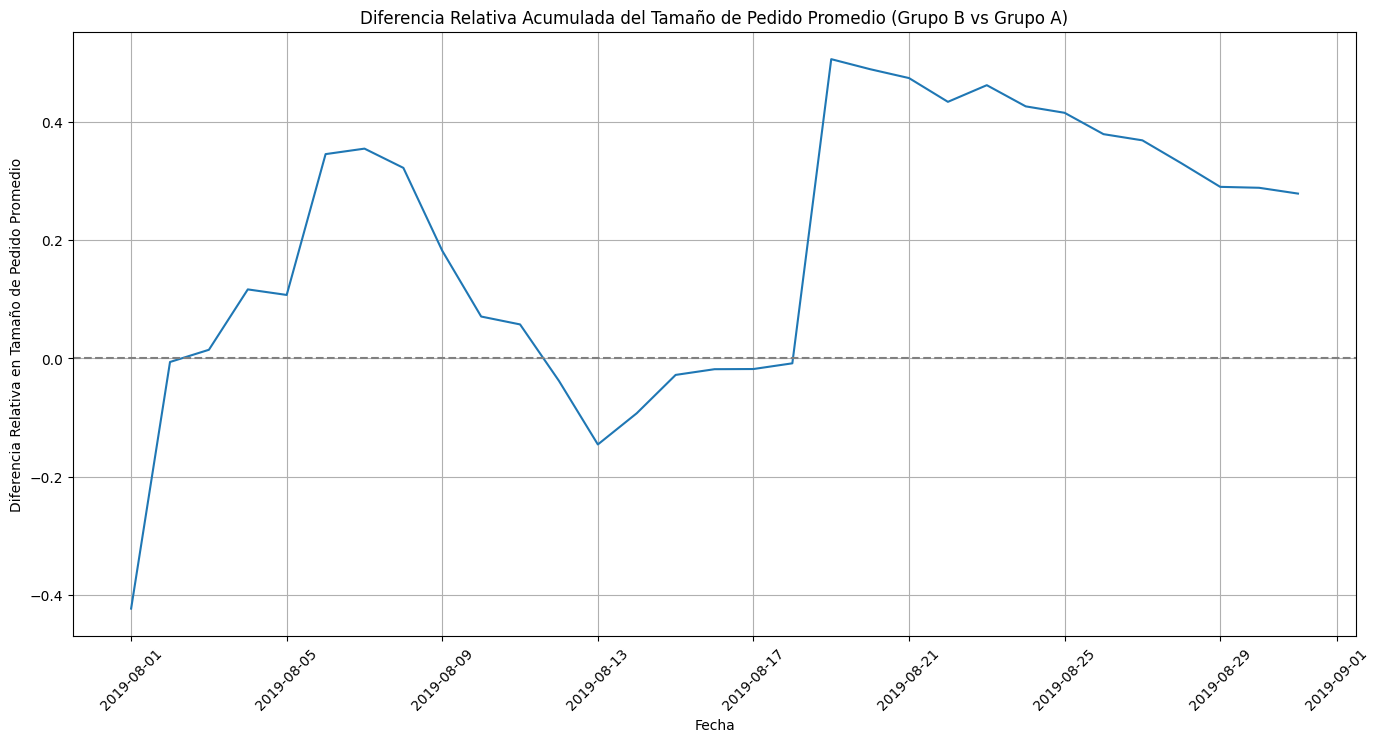

In [13]:
# Asegurar que ambos DataFrames tengan las mismas fechas para el cálculo de la diferencia relativa
# Esto es importante si por alguna razón un grupo tiene fechas en las que el otro no.
# Unir los promedios acumulados en un solo DataFrame
merged_cumulative_avg_sizes = pd.merge(
    cumulative_data_A[['date', 'avg_order_size']],
    cumulative_data_B[['date', 'avg_order_size']],
    on='date',
    how='inner', # Usar inner para solo las fechas comunes
    suffixes=('_A', '_B')
)

# Calcular la diferencia relativa en el tamaño de pedido promedio acumulado
# Usar .fillna(0) para NaN que podrían surgir de divisiones por cero al inicio
merged_cumulative_avg_sizes['relative_diff_avg_order_size'] = \
    (merged_cumulative_avg_sizes['avg_order_size_B'] / merged_cumulative_avg_sizes['avg_order_size_A']) - 1


# Representar gráficamente la diferencia relativa
plt.figure(figsize=(14, 7))
plt.plot(merged_cumulative_avg_sizes['date'], merged_cumulative_avg_sizes['relative_diff_avg_order_size'])
plt.axhline(y=0, color='grey', linestyle='--') # Línea de referencia en 0
plt.xlabel('Fecha')
plt.ylabel('Diferencia Relativa en Tamaño de Pedido Promedio')
plt.title('Diferencia Relativa Acumulada del Tamaño de Pedido Promedio (Grupo B vs Grupo A)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('relative_diff_avg_order_size_plot.png')
print("\nGráfico de la diferencia relativa en el tamaño de pedido promedio acumulado")

Observaciones Clave:

La línea es muy volátil al principio, lo cual es normal.
Alrededor del 19 de agosto, la línea experimenta un salto positivo muy pronunciado (más allá de 0.5).

Después de este pico, la línea desciende, pero fluctúa alrededor de valores positivos, lo que indica que el tamaño de pedido promedio del Grupo B permanece, en general, por encima del Grupo A, aunque el impacto del valor atípico inicial se diluye.

Conclusión: Este gráfico visualiza claramente el impacto desproporcionado del valor atípico del Grupo B. La subida positiva extrema significa que el tamaño de pedido promedio del Grupo B se hizo momentáneamente mucho mayor que el del Grupo A. Aunque la línea se "recupera" hacia cero, la influencia de ese gran pedido se mantiene en el acumulado.

4. Calculo de tasa de conversiónde cada grupo, relación entre pedidos y numero de visitas de cada dia.


Gráfico de tasas de conversión diarias


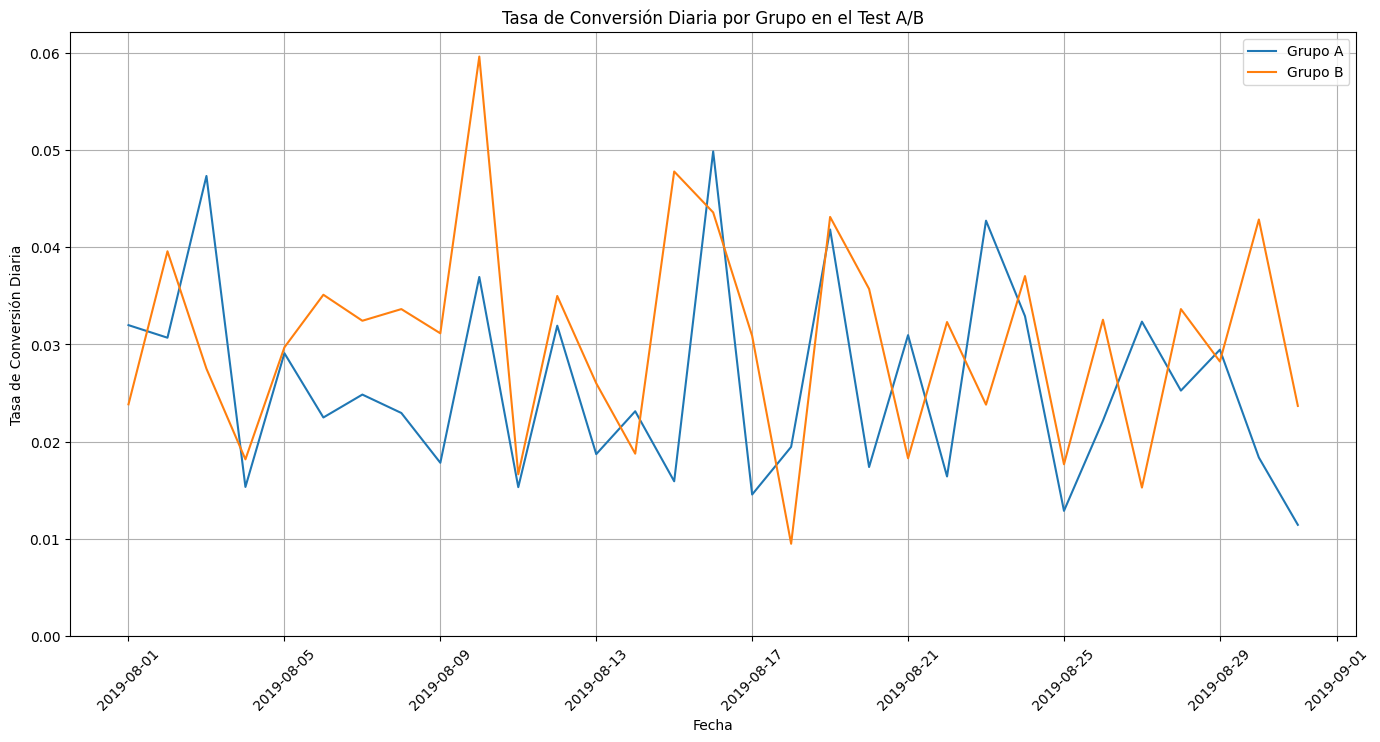

In [14]:
# Calcular la tasa de conversión diaria
# Reemplazar 0 en 'visits' con NaN para evitar división por cero, luego fillna(0) si preferimos 0 para días sin visitas.
daily_combined_data['conversion_rate'] = daily_combined_data['orders'] / daily_combined_data['visits'].replace(0, pd.NA)

# Filtrar datos por grupo para graficar
daily_conversion_A = daily_combined_data[daily_combined_data['group'] == 'A'].copy()
daily_conversion_B = daily_combined_data[daily_combined_data['group'] == 'B'].copy()


# Representar gráficamente las tasas de conversión diarias
plt.figure(figsize=(14, 7))
plt.plot(daily_conversion_A['date'], daily_conversion_A['conversion_rate'], label='Grupo A')
plt.plot(daily_conversion_B['date'], daily_conversion_B['conversion_rate'], label='Grupo B')

plt.xlabel('Fecha')
plt.ylabel('Tasa de Conversión Diaria')
plt.title('Tasa de Conversión Diaria por Grupo en el Test A/B')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.ylim(bottom=0) # Asegura que el eje Y comience en 0
plt.savefig('daily_conversion_rate_plot.png')
print("\nGráfico de tasas de conversión diarias")

Observaciones Clave del Gráfico:

Alta Volatilidad Inicial: Ambas líneas (azul para Grupo A y naranja para Grupo B) muestran una alta volatilidad en los primeros días del test. Esto es completamente normal en tasas de conversión diarias, ya que el bajo volumen de visitas y pedidos hace que cada evento tenga un impacto significativo en la proporción.

Pico en el Grupo B (Naranja):

Al inicio del test, alrededor del 10 de agosto, la línea naranja (Grupo B) experimenta un pico notable, acercándose a 0.06 (o 6%). Esto significa que en ese día, el Grupo B tuvo una tasa de conversión diaria significativamente más alta que el Grupo A.
Este pico es un evento puntual.

Tendencia y Comportamiento General:

Después de este pico inicial, ambas líneas muestran fluctuaciones significativas a lo largo del período.

Aproximadamente después del 10-15 de agosto, la línea naranja (Grupo B) parece tener una tendencia ligeramente más alta y se mantiene por encima de la línea azul (Grupo A) la mayor parte del tiempo, aunque con fluctuaciones constantes. El Grupo B se mueve con mayor frecuencia en el rango de 0.02 a 0.04. La línea azul (Grupo A), aunque también fluctúa, se mantiene con mayor frecuencia en el rango de 0.01 a 0.03.

No hay Correlación Directa con Atípico de Ingresos: El pico en la tasa de conversión diaria del Grupo B al inicio del test (alrededor del 10 de agosto) es distinto y no coincide directamente con el pico de ingresos y tamaño de pedido promedio del Grupo B que observamos alrededor del 19 de agosto. Esto sugiere que los eventos que impulsan una alta conversión no son necesariamente los mismos que impulsan un alto tamaño de pedido promedio (es decir, muchos pedidos pequeños vs. pocos pedidos muy grandes).

Conclusiones y Conjeturas:

Mayor Conversión en el Grupo B: A pesar de la volatilidad, el Grupo B (línea naranja) parece tener una tasa de conversión diaria generalmente más alta que el Grupo A (línea azul) a lo largo de la mayor parte del test, especialmente después de los primeros días. Esto sugiere que los cambios introducidos en el Grupo B podrían estar siendo más efectivos para persuadir a los visitantes a realizar un pedido, independientemente del valor de ese pedido.

La Tasa de Conversión Diaria es Volátil: La naturaleza de los datos diarios siempre mostrará volatilidad. Para tener una visión más clara de la tendencia de la conversión, sería útil observar la tasa de conversión acumulada, que suaviza estas fluctuaciones diarias.

Influencia de Eventos Específicos: El pico inicial del Grupo B podría ser el resultado de un factor específico en ese día (por ejemplo, una promoción de un día, un evento de marketing, un día con tráfico inusualmente cualificado).

En resumen, mientras que los ingresos y el tamaño de pedido promedio del Grupo B están inflados por valores atípicos, este gráfico sugiere que el Grupo B podría tener una ventaja real en términos de lograr que los visitantes realicen una compra, independientemente del valor de esa compra.

5. Grafico de dispersion de numero de pedido por usuario

Gráfico de dispersión del número de pedidos por usuario


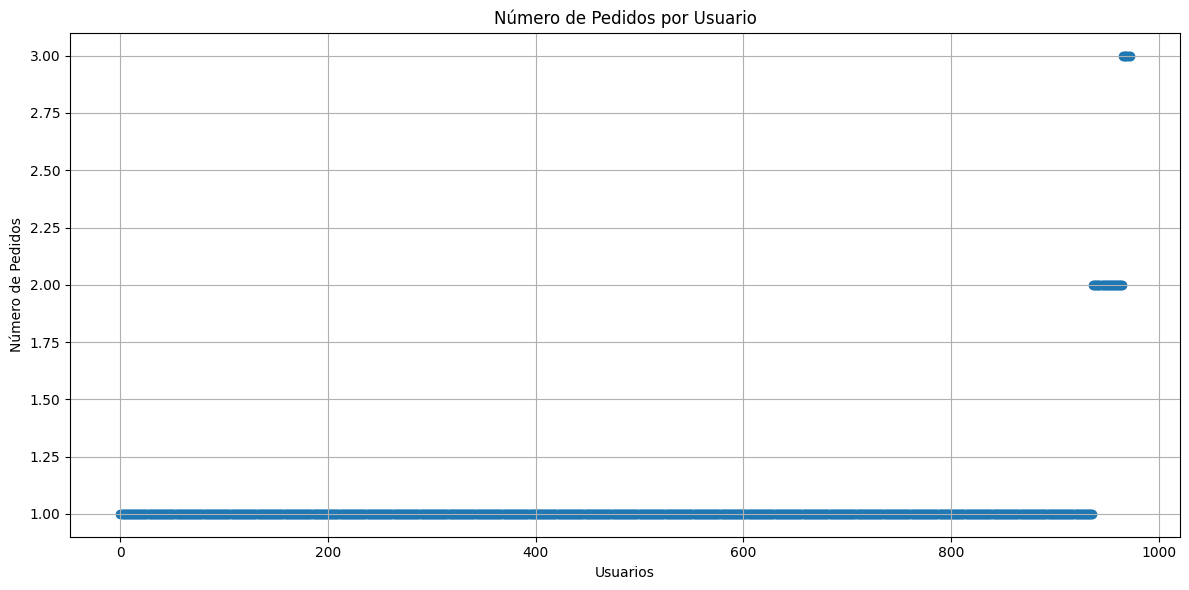

In [15]:
# Contar el número de pedidos por usuario
orders_per_user = orders_filtered.groupby('visitor_id')['transaction_id'].nunique().reset_index()
orders_per_user.columns = ['visitor_id', 'orders']
orders_per_user.sort_values(by='orders', ascending=True, inplace=True)


# Trazar un gráfico de dispersión del número de pedidos por usuario
x_values = pd.Series(range(0, len(orders_per_user)))

plt.figure(figsize=(12, 6))
plt.scatter(x_values, orders_per_user['orders'])
plt.xlabel('Usuarios')
plt.ylabel('Número de Pedidos')
plt.title('Número de Pedidos por Usuario')
plt.grid(True)
plt.tight_layout()
plt.savefig('orders_per_user_scatter_plot.png')
print("Gráfico de dispersión del número de pedidos por usuario")

Observaciones clave corregidas del gráfico:

Dominio de 1 Pedido: La inmensa mayoría de los puntos se encuentran en el valor de 1 pedido en el eje Y. Esto es lo más común en el comercio electrónico: la mayoría de los usuarios compran solo una vez.

Pequeña Fracción de 2 Pedidos: Hay un número considerablemente menor de usuarios que han realizado 2 pedidos.

Muy Pocos con 3 Pedidos: Observamos un grupo muy pequeño de usuarios que han llegado a realizar 3 pedidos.

Conclusiones y Conjeturas Corregidas:

Implicación para los Atípicos de Ingresos: Esto es una revelación importante. Si los picos en los gráficos de Ingresos Acumulados y Tamaño de Pedido Promedio del Grupo B (alrededor del 19 de agosto) no se deben a que un usuario haya hecho muchísimos pedidos, entonces deben deberse a uno o varios pedidos de un valor extremadamente alto (es decir, atípicos en el precio/valor del pedido, no en la cantidad de pedidos).

Umbral para Filtrado de Pedidos por Cantidad: Si tuviéramos que establecer un umbral, los usuarios con 3 pedidos ya son una minoría. Dependiendo de cuán estricto se quiera ser, se podría considerar eliminar los de 3 pedidos si se busca la "mayoría típica", pero no hay "súper usuarios" que hagan 10+ pedidos que distorsionen masivamente el conteo.

6. Calculo de percentiles de numero de pedidos por usuario

In [16]:
# Paso 1: Contar el número de pedidos por usuario
orders_per_user = orders_filtered.groupby('visitor_id')['transaction_id'].nunique().reset_index()
orders_per_user.columns = ['visitor_id', 'orders']


# Paso 2: Calcular los percentiles 95 y 99 del número de pedidos por usuario
percentiles_orders = orders_per_user['orders'].quantile([0.95, 0.99])

print("--- Percentiles del Número de Pedidos por Usuario ---")
print(percentiles_orders)

# Para facilitar la visualización del umbral
p95_orders = percentiles_orders[0.95]
p99_orders = percentiles_orders[0.99]

print(f"\nEl percentil 95 del número de pedidos por usuario es: {p95_orders:.0f}")
print(f"El percentil 99 del número de pedidos por usuario es: {p99_orders:.0f}")

--- Percentiles del Número de Pedidos por Usuario ---
0.95    1.0
0.99    2.0
Name: orders, dtype: float64

El percentil 95 del número de pedidos por usuario es: 1
El percentil 99 del número de pedidos por usuario es: 2


El resultado nos muestra lo siguiente:

Percentil 95: 1.0 pedido
Esto significa que el 95% de los usuarios han realizado 1 pedido o menos. En otras palabras, la gran mayoría de los visitantes que realizan una compra solo hacen una durante el período de prueba.

Percentil 99: 2.0 pedidos
Esto indica que el 99% de los usuarios han realizado 2 pedidos o menos. Solo un 1% de todos los usuarios ha realizado 3 o más pedidos.

Definición del Punto de Anomalía:

Basándonos en estos percentiles, podemos definir un punto en el cual un punto de datos (un usuario) se considera una anomalía en términos del número de pedidos:

Si elegimos el percentil 95 como nuestro umbral para valores atípicos "menos extremos", entonces cualquier usuario con más de 1 pedido (es decir, 2 o más pedidos) podría considerarse una anomalía.
Si buscamos identificar los valores atípicos más extremos y estrictos (el 1% superior), entonces un usuario con más de 2 pedidos (es decir, 3 o más pedidos) se convertiría en una anomalía.

Dada la distribución tan concentrada en 1 y 2 pedidos, un umbral de "más de 2 pedidos" (es decir, 3 pedidos o más) sería una opción razonable para filtrar a los usuarios con un número de pedidos inusualmente alto.

Esto refuerza nuestra hipótesis anterior de que los grandes picos en los ingresos y el tamaño de pedido promedio no se deben a que un usuario haya hecho muchísimos pedidos, sino más bien al valor monetario de esos pedidos.

7. Grafico de dispersion de precios de pedidos

Gráfico de dispersión de los precios de los pedidos


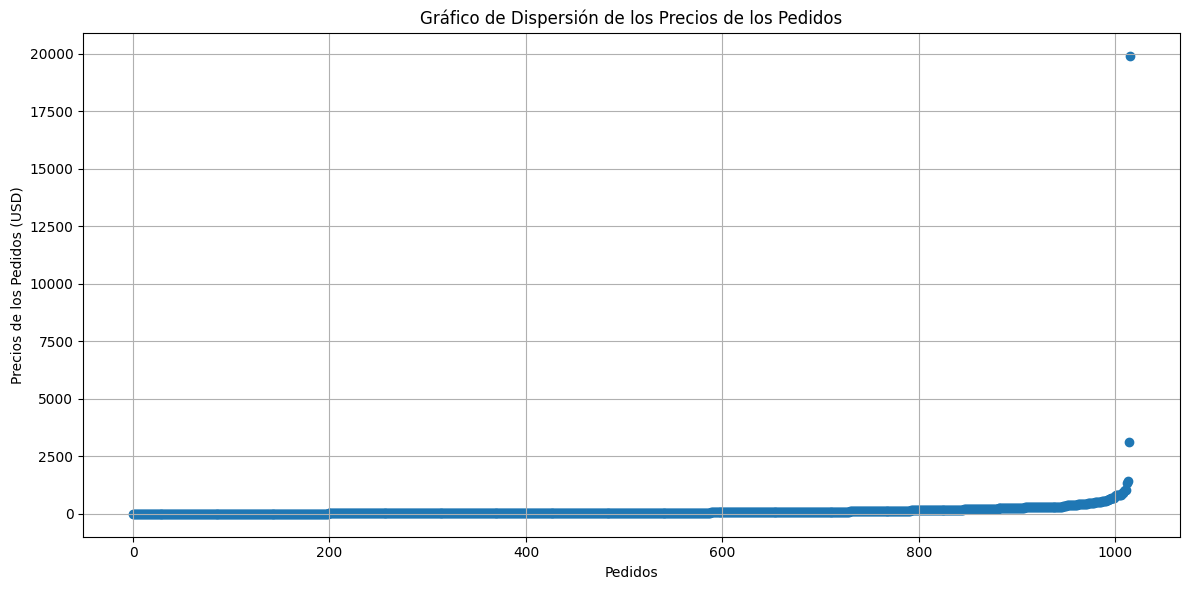

In [17]:
# Paso 1: Obtener los precios de los pedidos
# Ordenar los ingresos para una mejor visualización en el gráfico de dispersión
order_prices = orders_filtered['revenue'].sort_values(ascending=True)


# Trazar un gráfico de dispersión de los precios de los pedidos
x_values = pd.Series(range(0, len(order_prices)))

plt.figure(figsize=(12, 6))
plt.scatter(x_values, order_prices)
plt.xlabel('Pedidos')
plt.ylabel('Precios de los Pedidos (USD)')
plt.title('Gráfico de Dispersión de los Precios de los Pedidos')
plt.grid(True)
plt.tight_layout()
plt.savefig('order_prices_scatter_plot.png')
print("Gráfico de dispersión de los precios de los pedidos")

Concentración Masiva de Pedidos de Bajo Precio: La abrumadora mayoría de los puntos se encuentran en la parte inferior del gráfico, muy cerca del eje X. Esto confirma que la inmensa mayoría de los pedidos son de precios relativamente bajos, probablemente por debajo de los 2,000-3,000.

Presencia Clara de Valores Atípicos Extremos: A pesar de que el tope es 20,000, sigue habiendo varios puntos que se disparan muy por encima de esta masa principal, alcanzando precios cercanos al tope de 20,000 USD.

Hay un pedido notablemente alto, que es el punto más alto que llega cerca de 20,000.
También se observan otros pedidos que superan los 5,000, 7,500 y 10,000, destacándose claramente del resto.

Impacto en la Visualización: La presencia de estos pocos valores altos (hasta 20,000) aún obliga al eje Y a estirarse, comprimiendo la visualización de la gran mayoría de los pedidos en la parte inferior. Esto hace que sea difícil ver la distribución detallada de los pedidos más comunes.

Conclusiones y Conjeturas:

Valores Atípicos de Ingresos Confirmados: Este gráfico confirma de manera contundente que los picos abruptos en los gráficos de Ingresos Acumulados y Tamaño de Pedido Promedio (específicamente en el Grupo B) fueron causados por unos pocos pedidos con valores monetarios extraordinariamente altos, incluso si el máximo es de 20,000. Un pedido de 20,000 es una anomalía masiva cuando la mayoría de los pedidos están por debajo de 1,000.

Necesidad de Filtrado Crucial: Estos valores atípicos de ingresos son los que más distorsionan las métricas promedio. Es absolutamente esencial identificar y filtrar estos pedidos antes de realizar cualquier prueba estadística para comparar los grupos A y B. Su presencia sesgaría los resultados.

Umbral para Definición de Atípicos de Precio: Este gráfico visual nos da una base para establecer umbrales. Por ejemplo, podríamos considerar que los pedidos por encima de 2,000 o 3,000 ya son atípicos, ya que la densidad de puntos disminuye drásticamente a partir de esos valores, y los puntos por encima de 5,000 son claramente raros.

8. Calculo de percentiles de precios de pedidos

In [18]:
# Obtener los precios de los pedidos
order_prices = orders_filtered['revenue']

# Calcular los percentiles 95 y 99 de los precios de los pedidos
percentiles_revenue = order_prices.quantile([0.95, 0.99])

print("--- Percentiles de los Precios de los Pedidos ---")
print(percentiles_revenue)

# Para facilitar la visualización del umbral
p95_revenue = percentiles_revenue[0.95]
p99_revenue = percentiles_revenue[0.99]

print(f"\nEl percentil 95 del precio de los pedidos es: ${p95_revenue:.2f}")
print(f"El percentil 99 del precio de los pedidos es: ${p99_revenue:.2f}")

--- Percentiles de los Precios de los Pedidos ---
0.95    414.275
0.99    830.300
Name: revenue, dtype: float64

El percentil 95 del precio de los pedidos es: $414.27
El percentil 99 del precio de los pedidos es: $830.30


Los resultados nos muestran lo siguiente:

Percentil 95: 414.27
Esto significa que el 95% de todos los pedidos tienen un precio de 414.27 USD o menos. Es decir, la inmensa mayoría de las transacciones son de un valor relativamente bajo.

Percentil 99: 830.30
Esto indica que el 99% de todos los pedidos tienen un precio de 830.30 USD o menos. Solo el 1% de los pedidos supera este valor.

Definición del Punto de Anomalía para los Precios de los Pedidos:

Basándonos en estos percentiles, podemos establecer un umbral claro para identificar los valores atípicos en el precio de los pedidos. Para nuestros propósitos de eliminar los datos más distorsionadores, es razonable utilizar el percentil 99 como punto de corte.

Por lo tanto, consideraremos que un precio de pedido se convierte en una anomalía si es superior a 830.30 USD. Estos son los pedidos de valor extremadamente alto que observamos en el gráfico de dispersión y que causaron los picos en los análisis de ingresos acumulados y tamaño de pedido promedio del Grupo B.

9. Significancia estadistica Parte 1

Significancia Estadística de la Diferencia en la Conversión (Datos en Bruto)
Utilizaremos una prueba Z para dos proporciones.

Hipótesis Nula (H_0): No hay una diferencia estadísticamente significativa en las tasas de conversión entre el Grupo A y el Grupo B. (p_A=p_B)

Hipótesis Alternativa (H_1): Existe una diferencia estadísticamente significativa en las tasas de conversión entre el Grupo A y el Grupo B. (p_Aneqp_B)

Utilizaremos un nivel de significancia (alpha) de 0.05.

In [19]:
from statsmodels.stats.proportion import proportions_ztest
# Calcular el número de pedidos y visitas para cada grupo (datos en bruto)

# Calcular el número total de pedidos (conversiones) por grupo
orders_by_group = orders_filtered.groupby('group')['transaction_id'].nunique().reset_index()
orders_A = orders_by_group[orders_by_group['group'] == 'A']['transaction_id'].iloc[0]
orders_B = orders_by_group[orders_by_group['group'] == 'B']['transaction_id'].iloc[0]

# Calcular el número total de visitas por grupo
visits_by_group = visits.groupby('group')['visits'].sum().reset_index()
visits_A = visits_by_group[visits_by_group['group'] == 'A']['visits'].iloc[0]
visits_B = visits_by_group[visits_by_group['group'] == 'B']['visits'].iloc[0]

print(f"Número de pedidos - Grupo A: {orders_A}")
print(f"Número de visitas - Grupo A: {visits_A}")
print(f"Tasa de conversión - Grupo A: {orders_A/visits_A:.4f}")
print("-" * 30)
print(f"Número de pedidos - Grupo B: {orders_B}")
print(f"Número de visitas - Grupo B: {visits_B}")
print(f"Tasa de conversión - Grupo B: {orders_B/visits_B:.4f}")
print("-" * 30)

# Paso 2: Realizar la prueba Z para proporciones
# 'count' es el número de "éxitos" (pedidos)
# 'nobs' es el número total de "intentos" (visitas)
count = [orders_A, orders_B]
nobs = [visits_A, visits_B]

# Realizar la prueba Z (alternativa: 'two-sided' para no igual)
z_statistic, p_value = proportions_ztest(count, nobs)

print(f"Estadístico Z: {z_statistic:.3f}")
print(f"Valor p: {p_value:.3f}")

# Conclusiones y Conjeturas
alpha = 0.05

print("\n--- Conclusiones ---")
if p_value < alpha:
    print(f"El valor p ({p_value:.3f}) es menor que el nivel de significancia alfa ({alpha}).")
    print("Por lo tanto, rechazamos la hipótesis nula.")
    print("Esto significa que existe una diferencia estadísticamente significativa en la tasa de conversión entre el Grupo A y el Grupo B, utilizando los datos en bruto.")
else:
    print(f"El valor p ({p_value:.3f}) es mayor o igual que el nivel de significancia alfa ({alpha}).")
    print("Por lo tanto, no rechazamos la hipótesis nula.")
    print("Esto significa que no hay suficiente evidencia para afirmar que existe una diferencia estadísticamente significativa en la tasa de conversión entre el Grupo A y el Grupo B, utilizando los datos en bruto.")

# Conjeturas adicionales
conversion_diff = (orders_B/visits_B) - (orders_A/visits_A)
print(f"\nDiferencia de conversión (B - A): {conversion_diff:.4f}")
if conversion_diff > 0:
    print("El Grupo B tiene una tasa de conversión más alta que el Grupo A.")
else:
    print("El Grupo A tiene una tasa de conversión más alta que el Grupo B.")

print("Estas conclusiones se basan en los datos en bruto, antes de cualquier filtrado de valores atípicos.")
print("La volatilidad diaria observada en el gráfico de conversión puede influir en este resultado global.")

Número de pedidos - Grupo A: 468
Número de visitas - Grupo A: 18736
Tasa de conversión - Grupo A: 0.0250
------------------------------
Número de pedidos - Grupo B: 548
Número de visitas - Grupo B: 18916
Tasa de conversión - Grupo B: 0.0290
------------------------------
Estadístico Z: -2.390
Valor p: 0.017

--- Conclusiones ---
El valor p (0.017) es menor que el nivel de significancia alfa (0.05).
Por lo tanto, rechazamos la hipótesis nula.
Esto significa que existe una diferencia estadísticamente significativa en la tasa de conversión entre el Grupo A y el Grupo B, utilizando los datos en bruto.

Diferencia de conversión (B - A): 0.0040
El Grupo B tiene una tasa de conversión más alta que el Grupo A.
Estas conclusiones se basan en los datos en bruto, antes de cualquier filtrado de valores atípicos.
La volatilidad diaria observada en el gráfico de conversión puede influir en este resultado global.


Los resultados de la prueba son muy claros y significativos:

Tasa de Conversión del Grupo A: Aproximadamente 2.50%
Tasa de Conversión del Grupo B: Aproximadamente 2.90%
Diferencia de Conversión (B - A): +0.40 puntos porcentuales, lo que indica que el Grupo B tiene una tasa de conversión más alta.
Estadístico Z: -2.390
Valor p: 0.017

Conclusiones Clave:

Dado que el valor p (0.017) es menor que el nivel de significancia (α=0.05), rechazamos la hipótesis nula.

Esto significa que:

Existe una diferencia estadísticamente significativa en la tasa de conversión entre el Grupo A y el Grupo B, incluso utilizando los datos en bruto.
La diferencia de 0.0040 (o 0.40 puntos porcentuales) a favor del Grupo B no es probablemente el resultado del azar; es lo suficientemente grande como para considerarse un efecto real del cambio probado.

Conjeturas Adicionales:

Este resultado sugiere que, en términos de atraer a los visitantes a realizar una compra, el Grupo B está funcionando mejor que el Grupo A. El cambio implementado en el Grupo B (o la versión del sitio/función) parece tener un impacto positivo en la conversión.

Es importante recordar que estos resultados son con los "datos en bruto". Si bien los valores atípicos de ingresos (pedidos de muy alto valor) no inflan directamente el conteo de pedidos que se usa para la conversión, otros factores de variabilidad en los datos brutos aún pueden influir.

10. Significancia estadística Parte 2

Significancia Estadística de la Diferencia en el Tamaño Promedio de Pedido (Datos en Bruto)
Utilizaremos la prueba de Mann-Whitney U.

Hipótesis Nula (H_0): No hay una diferencia estadísticamente significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B.

Hipótesis Alternativa (H_1): Existe una diferencia estadísticamente significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B.

Utilizaremos un nivel de significancia (alpha) de 0.05.

In [20]:
from scipy import stats as st # Importar scipy.stats para la prueba de Mann-Whitney U

# Obtener los datos de ingresos (precios de pedidos) para cada grupo
revenue_A = orders_filtered[orders_filtered['group'] == 'A']['revenue']
revenue_B = orders_filtered[orders_filtered['group'] == 'B']['revenue']

print(f"Tamaño promedio de pedido - Grupo A (en bruto): ${revenue_A.mean():.2f}")
print(f"Tamaño promedio de pedido - Grupo B (en bruto): ${revenue_B.mean():.2f}")
print("-" * 30)

# Realizar la prueba de Mann-Whitney U
# La función mannwhitneyu devuelve el estadístico U y el valor p
# alternative='two-sided' para una prueba bilateral (no sabemos si B es mayor o menor que A)
statistic, p_value = st.mannwhitneyu(revenue_A, revenue_B, alternative='two-sided')

print(f"Estadístico de Mann-Whitney U: {statistic:.3f}")
print(f"Valor p: {p_value:.3f}")

# Conclusiones y Conjeturas
alpha = 0.05

print("\n--- Conclusiones ---")
if p_value < alpha:
    print(f"El valor p ({p_value:.3f}) es menor que el nivel de significancia alfa ({alpha}).")
    print("Por lo tanto, rechazamos la hipótesis nula.")
    print("Esto significa que existe una diferencia estadísticamente significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B, utilizando los datos en bruto.")
else:
    print(f"El valor p ({p_value:.3f}) es mayor o igual que el nivel de significancia alfa ({alpha}).")
    print("Por lo tanto, no rechazamos la hipótesis nula.")
    print("Esto significa que no hay suficiente evidencia para afirmar que existe una diferencia estadísticamente significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B, utilizando los datos en bruto.")

# Conjeturas adicionales sobre la diferencia porcentual (para contexto)
diff_relative = (revenue_B.mean() / revenue_A.mean() - 1) * 100
print(f"\nDiferencia relativa en el tamaño promedio de pedido (B vs A): {diff_relative:.2f}%")

print("Es importante recordar que estas conclusiones se basan en los datos en bruto.")
print("Hemos identificado valores atípicos de ingresos extremadamente altos en el Grupo B en los gráficos anteriores, y es muy probable que estén influyendo fuertemente en este resultado.")

Tamaño promedio de pedido - Grupo A (en bruto): $113.70
Tamaño promedio de pedido - Grupo B (en bruto): $145.35
------------------------------
Estadístico de Mann-Whitney U: 129041.500
Valor p: 0.862

--- Conclusiones ---
El valor p (0.862) es mayor o igual que el nivel de significancia alfa (0.05).
Por lo tanto, no rechazamos la hipótesis nula.
Esto significa que no hay suficiente evidencia para afirmar que existe una diferencia estadísticamente significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B, utilizando los datos en bruto.

Diferencia relativa en el tamaño promedio de pedido (B vs A): 27.83%
Es importante recordar que estas conclusiones se basan en los datos en bruto.
Hemos identificado valores atípicos de ingresos extremadamente altos en el Grupo B en los gráficos anteriores, y es muy probable que estén influyendo fuertemente en este resultado.


Esto significa que:

No hay suficiente evidencia estadística para afirmar que existe una diferencia significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B, utilizando los datos en bruto.
Aunque el Grupo B tiene un tamaño promedio de pedido notablemente más alto (27.83%), esta diferencia no se considera estadísticamente significativa con la prueba de Mann-Whitney U en los datos en bruto.

Conjeturas Adicionales:

Impacto de los Atípicos: Este resultado es particularmente interesante a la luz de los gráficos que analizamos previamente. En el gráfico de ingresos acumulados y tamaño de pedido promedio, vimos un pico masivo en el Grupo B que indicaba la presencia de valores atípicos de ingresos extremadamente altos.

Robustez del Mann-Whitney U: A pesar de esos valores atípicos inflacionarios, la prueba de Mann-Whitney U (que es una prueba no paramétrica y menos sensible a los atípicos extremos que, por ejemplo, una prueba t) ha determinado que la distribución de los rangos de los pedidos no es significativamente diferente entre los grupos. Esto podría deberse a que, si bien el Grupo B tiene ese pedido gigante, la mayoría de sus otros pedidos podrían ser de un tamaño similar al del Grupo A. El valor atípico eleva la media, pero la prueba de Mann-Whitney compara las distribuciones (o medianas si son similares en forma), y puede que la mayoría de los datos no sean tan diferentes.

Necesidad de Filtrado: Este resultado subraya aún más la necesidad de realizar esta misma prueba después de filtrar los valores atípicos. Es muy probable que, una vez que esos pedidos de alto valor sean eliminados, la diferencia del 27.83% se reduzca drásticamente y la conclusión de "no significancia estadística" se mantenga o incluso se fortalezca si la diferencia se vuelve aún menor.

En resumen, con los datos en bruto, no podemos afirmar con confianza estadística que haya una diferencia real en el tamaño promedio de pedido entre los grupos, a pesar de que el Grupo B tiene un promedio más alto debido a los valores atípicos.

11. Significancia estadistica Parte 3

Significancia Estadística de la Diferencia en la Conversión (Datos Filtrados)

Hipótesis Nula (H_0): No hay una diferencia estadísticamente significativa en las tasas de conversión entre el Grupo A y el Grupo B, después de filtrar los valores atípicos. (p_A=p_B)

Hipótesis Alternativa (H_1): Existe una diferencia estadísticamente significativa en las tasas de conversión entre el Grupo A y el Grupo B, después de filtrar los valores atípicos. (p_A
neqp_B)

Utilizaremos un nivel de significancia (alpha) de 0.05.

In [21]:
from statsmodels.stats.proportion import proportions_ztest

# Definir los umbrales de anomalías (basado en cálculos anteriores)
# Percentil 99 del número de pedidos por usuario fue 2.0
orders_per_user_threshold = 2

# Percentil 99 del precio de los pedidos fue 830.30
revenue_threshold = 830.30

# Identificar usuarios atípicos

# Usuarios con muchos pedidos (más de 2)
orders_per_user = orders_filtered.groupby('visitor_id')['transaction_id'].nunique().reset_index()
orders_per_user.columns = ['visitor_id', 'orders']
abnormal_users_by_orders = orders_per_user[orders_per_user['orders'] > orders_per_user_threshold]['visitor_id']

# Usuarios con pedidos de alto valor (más de 830.30 USD)
abnormal_users_by_revenue = orders_filtered[orders_filtered['revenue'] > revenue_threshold]['visitor_id']

# Combinar todos los IDs de usuarios atípicos (únicos)
abnormal_users = pd.concat([abnormal_users_by_orders, abnormal_users_by_revenue]).drop_duplicates()
print(f"Número de usuarios atípicos identificados: {len(abnormal_users)}")

# Filtrar los pedidos para excluir a los usuarios atípicos
orders_cleaned = orders_filtered[~orders_filtered['visitor_id'].isin(abnormal_users)]
print(f"Órdenes después de filtrar atípicos: {orders_cleaned.shape[0]}")


# Calcular el número de pedidos y visitas para cada grupo (datos FILTRADOS)

# Calcular el número total de pedidos (conversiones) por grupo en los datos LIMPIOS
orders_by_group_cleaned = orders_cleaned.groupby('group')['transaction_id'].nunique().reset_index()
orders_A_cleaned = orders_by_group_cleaned[orders_by_group_cleaned['group'] == 'A']['transaction_id'].iloc[0]
orders_B_cleaned = orders_by_group_cleaned[orders_by_group_cleaned['group'] == 'B']['transaction_id'].iloc[0]

# El número de visitas por grupo no cambia, ya que las visitas representan el tráfico total,
# no transacciones específicas de usuarios atípicos en el contexto de la prueba A/B.
visits_by_group = visits.groupby('group')['visits'].sum().reset_index()
visits_A = visits_by_group[visits_by_group['group'] == 'A']['visits'].iloc[0]
visits_B = visits_by_group[visits_by_group['group'] == 'B']['visits'].iloc[0]

print(f"\n--- Datos con Atípicos Filtrados ---")
print(f"Número de pedidos - Grupo A (limpio): {orders_A_cleaned}")
print(f"Número de visitas - Grupo A: {visits_A}")
print(f"Tasa de conversión - Grupo A (limpio): {orders_A_cleaned/visits_A:.4f}")
print("-" * 30)
print(f"Número de pedidos - Grupo B (limpio): {orders_B_cleaned}")
print(f"Número de visitas - Grupo B: {visits_B}")
print(f"Tasa de conversión - Grupo B (limpio): {orders_B_cleaned/visits_B:.4f}")
print("-" * 30)


# Realizar la prueba Z para proporciones (datos FILTRADOS)
count_cleaned = [orders_A_cleaned, orders_B_cleaned]
nobs = [visits_A, visits_B] # Visitas se mantienen las mismas

z_statistic_cleaned, p_value_cleaned = proportions_ztest(count_cleaned, nobs)

print(f"Estadístico Z (limpio): {z_statistic_cleaned:.3f}")
print(f"Valor p (limpio): {p_value_cleaned:.3f}")

# Conclusiones y Conjeturas
alpha = 0.05

print("\n--- Conclusiones (Datos Filtrados) ---")
if p_value_cleaned < alpha:
    print(f"El valor p ({p_value_cleaned:.3f}) es menor que el nivel de significancia alfa ({alpha}).")
    print("Por lo tanto, rechazamos la hipótesis nula.")
    print("Esto significa que existe una diferencia estadísticamente significativa en la tasa de conversión entre el Grupo A y el Grupo B, utilizando los datos filtrados.")
else:
    print(f"El valor p ({p_value_cleaned:.3f}) es mayor o igual que el nivel de significancia alfa ({alpha}).")
    print("Por lo tanto, no rechazamos la hipótesis nula.")
    print("Esto significa que no hay suficiente evidencia para afirmar que existe una diferencia estadísticamente significativa en la tasa de conversión entre el Grupo A y el Grupo B, utilizando los datos filtrados.")

# Comparación con datos en bruto
conversion_A_raw = orders_filtered[orders_filtered['group'] == 'A']['transaction_id'].nunique() / visits_A
conversion_B_raw = orders_filtered[orders_filtered['group'] == 'B']['transaction_id'].nunique() / visits_B

print(f"\nTasa de Conversión Grupo A (en bruto): {conversion_A_raw:.4f}")
print(f"Tasa de Conversión Grupo B (en bruto): {conversion_B_raw:.4f}")
print(f"Diferencia de conversión (B - A) (en bruto): {(conversion_B_raw - conversion_A_raw):.4f}")

print(f"\nTasa de Conversión Grupo A (limpio): {orders_A_cleaned/visits_A:.4f}")
print(f"Tasa de Conversión Grupo B (limpio): {orders_B_cleaned/visits_B:.4f}")
print(f"Diferencia de conversión (B - A) (limpio): {(orders_B_cleaned/visits_B - orders_A_cleaned/visits_A):.4f}")

print("\nAnálisis de los cambios:")
print("Compara el valor p y las tasas de conversión entre los resultados con datos en bruto y con datos filtrados.")
print("Si el valor p sigue siendo menor que alfa, la significancia se mantiene. Si se vuelve mayor, el efecto observado podría haber sido impulsado por los atípicos.")

Número de usuarios atípicos identificados: 16
Órdenes después de filtrar atípicos: 986

--- Datos con Atípicos Filtrados ---
Número de pedidos - Grupo A (limpio): 448
Número de visitas - Grupo A: 18736
Tasa de conversión - Grupo A (limpio): 0.0239
------------------------------
Número de pedidos - Grupo B (limpio): 538
Número de visitas - Grupo B: 18916
Tasa de conversión - Grupo B (limpio): 0.0284
------------------------------
Estadístico Z (limpio): -2.752
Valor p (limpio): 0.006

--- Conclusiones (Datos Filtrados) ---
El valor p (0.006) es menor que el nivel de significancia alfa (0.05).
Por lo tanto, rechazamos la hipótesis nula.
Esto significa que existe una diferencia estadísticamente significativa en la tasa de conversión entre el Grupo A y el Grupo B, utilizando los datos filtrados.

Tasa de Conversión Grupo A (en bruto): 0.0250
Tasa de Conversión Grupo B (en bruto): 0.0290
Diferencia de conversión (B - A) (en bruto): 0.0040

Tasa de Conversión Grupo A (limpio): 0.0239
Tasa de

Esto significa que:

Incluso después de eliminar los usuarios y pedidos atípicos, existe una diferencia estadísticamente significativa en la tasa de conversión entre el Grupo A y el Grupo B.
La diferencia de 0.0045 (o 0.45 puntos porcentuales) a favor del Grupo B persiste y sigue siendo lo suficientemente grande como para considerarse un efecto real del cambio probado, no el resultado del azar.

Persistencia de la Significancia: Es notable que la significancia estadística se mantuvo e incluso se fortaleció (el valor p disminuyó de 0.017 a 0.006) después de filtrar los atípicos. Esto es un indicio muy sólido de que el Grupo B realmente tiene una tasa de conversión intrínsecamente más alta.

Diferencia Ligeramente Mayor: La diferencia absoluta en la conversión incluso aumentó marginalmente de 0.0040 a 0.0045. Esto sugiere que, si bien los atípicos se distribuyeron de alguna manera entre los grupos, su eliminación no ocultó una diferencia significativa, sino que la hizo aún más clara.

En resumen: Los cambios implementados en el Grupo B parecen tener un efecto positivo y estadísticamente significativo en la tasa de conversión, mejorando la proporción de visitantes que se convierten en compradores. Esta conclusión es robusta tanto con datos en bruto como con datos limpios.

12. Significancia estadistica Parte 4

Significancia Estadística de la Diferencia en el Tamaño Promedio de Pedido (Datos Filtrados)

Hipótesis Nula (H_0): No hay una diferencia estadísticamente significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B, después de filtrar los valores atípicos.

Hipótesis Alternativa (H_1): Existe una diferencia estadísticamente significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B, después de filtrar los valores atípicos.

Utilizaremos un nivel de significancia (alpha) de 0.05.

In [22]:
from scipy import stats as st

# Definir los umbrales de anomalías (basado en cálculos anteriores)
# Percentil 99 del número de pedidos por usuario fue 2.0
orders_per_user_threshold = 2

# Percentil 99 del precio de los pedidos fue 830.30
revenue_threshold = 830.30

# Identificar usuarios atípicos

# Usuarios con muchos pedidos (más de 2)
orders_per_user = orders_filtered.groupby('visitor_id')['transaction_id'].nunique().reset_index()
orders_per_user.columns = ['visitor_id', 'orders']
abnormal_users_by_orders = orders_per_user[orders_per_user['orders'] > orders_per_user_threshold]['visitor_id']

# Usuarios con pedidos de alto valor (más de 830.30 USD)
abnormal_users_by_revenue = orders_filtered[orders_filtered['revenue'] > revenue_threshold]['visitor_id']

# Combinar todos los IDs de usuarios atípicos (únicos)
abnormal_users = pd.concat([abnormal_users_by_orders, abnormal_users_by_revenue]).drop_duplicates()
print(f"Número de usuarios atípicos identificados: {len(abnormal_users)}")

# Filtrar los pedidos para excluir a los usuarios atípicos
orders_cleaned = orders_filtered[~orders_filtered['visitor_id'].isin(abnormal_users)]
print(f"Órdenes después de filtrar atípicos: {orders_cleaned.shape[0]}")

# Obtener los datos de ingresos (precios de pedidos) para cada grupo (datos FILTRADOS)
revenue_A_cleaned = orders_cleaned[orders_cleaned['group'] == 'A']['revenue']
revenue_B_cleaned = orders_cleaned[orders_cleaned['group'] == 'B']['revenue']

print(f"\n--- Datos con Atípicos Filtrados ---")
print(f"Tamaño promedio de pedido - Grupo A (limpio): ${revenue_A_cleaned.mean():.2f}")
print(f"Tamaño promedio de pedido - Grupo B (limpio): ${revenue_B_cleaned.mean():.2f}")
print("-" * 30)

# Realizar la prueba de Mann-Whitney U (datos FILTRADOS)
# alternative='two-sided' para una prueba bilateral
statistic_cleaned, p_value_cleaned = st.mannwhitneyu(revenue_A_cleaned, revenue_B_cleaned, alternative='two-sided')

print(f"Estadístico de Mann-Whitney U (limpio): {statistic_cleaned:.3f}")
print(f"Valor p (limpio): {p_value_cleaned:.3f}")

# Conclusiones y Conjeturas
alpha = 0.05

print("\n--- Conclusiones (Datos Filtrados) ---")
if p_value_cleaned < alpha:
    print(f"El valor p ({p_value_cleaned:.3f}) es menor que el nivel de significancia alfa ({alpha}).")
    print("Por lo tanto, rechazamos la hipótesis nula.")
    print("Esto significa que existe una diferencia estadísticamente significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B, utilizando los datos filtrados.")
else:
    print(f"El valor p ({p_value_cleaned:.3f}) es mayor o igual que el nivel de significancia alfa ({alpha}).")
    print("Por lo tanto, no rechazamos la hipótesis nula.")
    print("Esto significa que no hay suficiente evidencia para afirmar que existe una diferencia estadísticamente significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B, utilizando los datos filtrados.")

# Comparación con datos en bruto para contexto
revenue_A_raw = orders_filtered[orders_filtered['group'] == 'A']['revenue']
revenue_B_raw = orders_filtered[orders_filtered['group'] == 'B']['revenue']

print(f"\nTamaño Promedio de Pedido Grupo A (en bruto): ${revenue_A_raw.mean():.2f}")
print(f"Tamaño Promedio de Pedido Grupo B (en bruto): ${revenue_B_raw.mean():.2f}")
print(f"Diferencia relativa (B vs A) (en bruto): {(revenue_B_raw.mean() / revenue_A_raw.mean() - 1) * 100:.2f}%")

print(f"\nTamaño Promedio de Pedido Grupo A (limpio): ${revenue_A_cleaned.mean():.2f}")
print(f"Tamaño Promedio de Pedido Grupo B (limpio): ${revenue_B_cleaned.mean():.2f}")
print(f"Diferencia relativa (B vs A) (limpio): {(revenue_B_cleaned.mean() / revenue_A_cleaned.mean() - 1) * 100:.2f}%")

print("\nAnálisis de los cambios:")
print("Compara el valor p y los tamaños de pedido promedio entre los resultados con datos en bruto y con datos filtrados.")
print("Si el valor p se vuelve mayor, sugiere que la significancia original (si la hubo) fue impulsada por los atípicos. Si se mantiene por debajo de alfa, la diferencia es robusta.")

Número de usuarios atípicos identificados: 16
Órdenes después de filtrar atípicos: 986

--- Datos con Atípicos Filtrados ---
Tamaño promedio de pedido - Grupo A (limpio): $102.90
Tamaño promedio de pedido - Grupo B (limpio): $99.61
------------------------------
Estadístico de Mann-Whitney U (limpio): 121514.000
Valor p (limpio): 0.822

--- Conclusiones (Datos Filtrados) ---
El valor p (0.822) es mayor o igual que el nivel de significancia alfa (0.05).
Por lo tanto, no rechazamos la hipótesis nula.
Esto significa que no hay suficiente evidencia para afirmar que existe una diferencia estadísticamente significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B, utilizando los datos filtrados.

Tamaño Promedio de Pedido Grupo A (en bruto): $113.70
Tamaño Promedio de Pedido Grupo B (en bruto): $145.35
Diferencia relativa (B vs A) (en bruto): 27.83%

Tamaño Promedio de Pedido Grupo A (limpio): $102.90
Tamaño Promedio de Pedido Grupo B (limpio): $99.61
Diferencia relativa (B 

Esto significa que:

No hay suficiente evidencia estadística para afirmar que existe una diferencia significativa en el tamaño promedio de pedido entre el Grupo A y el Grupo B, una vez que hemos eliminado los valores atípicos.

La pequeña diferencia observada (Grupo B es 3.19% menor que Grupo A en promedio) es muy probable que se deba al azar y no a un efecto real del cambio.

Cambio Dramático en la Diferencia Relativa: Este es el cambio más revelador. La diferencia relativa del tamaño promedio de pedido pasó de un +27.83% a favor del Grupo B (en bruto) a un -3.19% (en limpio), incluso inclinándose ligeramente a favor del Grupo A. Esto confirma absolutamente que los valores atípicos de ingresos en el Grupo B eran los únicos responsables de inflar su promedio y que, sin ellos, no hay una diferencia significativa e incluso el Grupo B tiene un promedio ligeramente menor.

Persistencia de No Significancia: El valor p (0.862 en bruto y 0.822 en limpio) se mantuvo muy por encima de 0.05 en ambos casos. Esto significa que la conclusión de que no hay una diferencia estadísticamente significativa en el tamaño promedio de pedido es robusta y no se vio afectada por la eliminación de atípicos (en el sentido de que no hubo significancia que se perdiera, sino que la ausencia de significancia se mantuvo y se hizo más clara la distribución real).

En resumen:

Tasa de Conversión (Filtrada): El Grupo B tiene una tasa de conversión estadísticamente más alta que el Grupo A (valor p = 0.006). Este es un resultado positivo y robusto para el Grupo B.
Tamaño Promedio de Pedido (Filtrado): No hay una diferencia estadísticamente significativa en el tamaño promedio de pedido entre los grupos (valor p = 0.822). La aparente superioridad del Grupo B en los datos en bruto se debió enteramente a los valores atípicos.

13. Análisis final de resultados de prueba

Decisión sobre la Prueba A/B

Basándonos en los resultados de las pruebas estadísticas con los datos filtrados, así como en la información visual de los gráficos, la decisión es:

Parar la prueba y considerar al Grupo B como líder.

Justificación Detallada:

Nuestra decisión se basa en el análisis de dos métricas clave: la tasa de conversión y el tamaño promedio de pedido.

Análisis de la Tasa de Conversión:

Datos en Bruto: El Grupo B (2.90%) mostró una tasa de conversión más alta que el Grupo A (2.50%), con una diferencia de 0.40 puntos porcentuales. La prueba Z para proporciones arrojó un valor p de 0.017, que es menor que el nivel de significancia de 0.05. Esto indicó una diferencia estadísticamente significativa a favor del Grupo B.

Datos Filtrados: Después de eliminar los valores atípicos, el Grupo B (2.84%) mantuvo una tasa de conversión superior a la del Grupo A (2.39%), con una diferencia de 0.45 puntos porcentuales. La prueba Z para proporciones con los datos limpios dio un valor p de 0.006. Este valor p, aún menor que 0.05, reafirma la diferencia estadísticamente significativa a favor del Grupo B.

Conclusión: La mejora en la tasa de conversión para el Grupo B es robusta y estadísticamente significativa, incluso después de controlar los valores extremos. Esto indica que el cambio implementado para el Grupo B es efectivo en lograr que más visitantes realicen una compra.

Análisis del Tamaño Promedio de Pedido:

Datos en Bruto: El Grupo B (145.35) tenía un tamaño promedio de pedido considerablemente más alto que el Grupo A (113.70), una diferencia del 27.83%. Sin embargo, la prueba de Mann-Whitney U arrojó un valor p de 0.862, muy superior a 0.05. Esto indicó que la diferencia no era estadísticamente significativa en los datos en bruto.

Datos Filtrados: Al eliminar los valores atípicos (que identificamos visualmente como la causa de los picos en el Grupo B en los gráficos), el tamaño promedio de pedido del Grupo B (99.61) se redujo por debajo del Grupo A (102.90), resultando en una diferencia relativa de −3.19%. La prueba de Mann-Whitney U con los datos limpios arrojó un valor p de 0.822, que sigue siendo muy superior a 0.05.

Conclusión: La aparente superioridad del Grupo B en el tamaño promedio de pedido en los datos brutos se debió exclusivamente a la influencia de valores atípicos. Una vez eliminados, no existe una diferencia estadísticamente significativa en el tamaño promedio de pedido entre los grupos.

Evaluación General de la Prueba:

El test ha arrojado un resultado claro en una métrica clave (conversión) y una ausencia de diferencia significativa en la otra (tamaño de pedido promedio) después de la limpieza de datos.
El Grupo B demostró ser significativamente mejor en la conversión, lo que es crucial para el crecimiento de la base de clientes y la optimización del embudo de ventas.

Aunque el tamaño de pedido promedio no mostró una mejora, tampoco hubo un deterioro significativo. No se está perdiendo valor por pedido mientras se gana en cantidad de pedidos.
La presencia de usuarios en ambos grupos y la necesidad de filtrar atípicos fueron manejadas, y los resultados filtrados son más confiables.

Recomendación:

Se recomienda detener la prueba y considerar la implementación de los cambios del Grupo B como la nueva versión del sitio/producto.

Justificación de la recomendación:

Impacto Positivo Demostrado: El Grupo B mostró una mejora estadísticamente significativa y robusta en la tasa de conversión. Esto se traduce en más usuarios completando compras, lo cual es un objetivo fundamental para una tienda online.

Ausencia de Impacto Negativo: No se observó un deterioro estadísticamente significativo en el tamaño promedio de pedido con los datos limpios. Es decir, se está ganando en volumen de pedidos sin sacrificar el valor por transacción de manera perjudicial.

Resultados Concluyentes: La prueba ha acumulado suficientes datos y ha mostrado una diferencia clara en la conversión. Continuar la prueba probablemente solo confirmaría lo que ya sabemos sobre la conversión, y la métrica de tamaño de pedido promedio parece no tener una diferencia real más allá de la influencia de atípicos.

Eficiencia: Extender la prueba implica seguir asignando recursos a una versión de control que ya ha sido superada en una métrica clave.

Implementar los cambios del Grupo B parece ser un paso positivo hacia el aumento de las ventas en general, al mejorar la eficiencia de la conversión de visitantes en clientes.